<a href="https://colab.research.google.com/github/gtejaswani/sample/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 9.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
     |████████████████████████████████| 10.5MB 2.6MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.2 which is incompatible.
  Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path=("/content/drive/My Drive/Copy of 1.csv")
df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 520 ms, sys: 1.93 ms, total: 522 ms
Wall time: 527 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

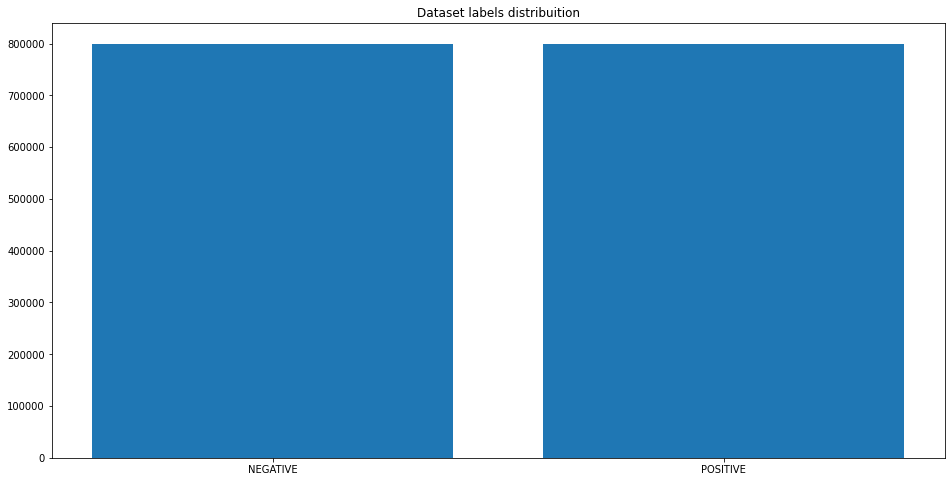

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 44.8 s, sys: 272 ms, total: 45.1 s
Wall time: 45.2 s


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 
import os
path=("/content/drive/My Drive/Copy of model.w2v")
model_exists = os.path.isfile('path')

CPU times: user 3.48 s, sys: 446 ms, total: 3.93 s
Wall time: 3.93 s


In [ ]:
if model_exists:
    from gensim.models import Word2Vec
    w2v_model=Word2Vec.load(r"/content/drive/My Drive/Colab Notebooks/model.w2v")
    print("w2v model exists, existing model loaded.")
else:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
if not model_exists:
    w2v_model.build_vocab(documents)

2020-09-22 15:40:09,720 : INFO : collecting all words and their counts
2020-09-22 15:40:09,722 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-22 15:40:09,755 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-09-22 15:40:09,782 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-09-22 15:40:09,811 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-09-22 15:40:09,838 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-09-22 15:40:09,865 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-09-22 15:40:09,893 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-09-22 15:40:09,924 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-09-22 15:40:09,954 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
w2v_model.wv['model'].shape

(300,)

In [ ]:
%%time
if model_exists==False:
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
else:
    print("Trained model loaded")

2020-09-22 15:40:36,709 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-09-22 15:40:37,773 : INFO : EPOCH 1 - PROGRESS: at 3.47% examples, 272804 words/s, in_qsize 15, out_qsize 0
2020-09-22 15:40:38,779 : INFO : EPOCH 1 - PROGRESS: at 7.71% examples, 308365 words/s, in_qsize 16, out_qsize 1
2020-09-22 15:40:39,801 : INFO : EPOCH 1 - PROGRESS: at 11.51% examples, 307354 words/s, in_qsize 16, out_qsize 0
2020-09-22 15:40:40,804 : INFO : EPOCH 1 - PROGRESS: at 15.52% examples, 312563 words/s, in_qsize 15, out_qsize 0
2020-09-22 15:40:41,874 : INFO : EPOCH 1 - PROGRESS: at 19.40% examples, 309889 words/s, in_qsize 13, out_qsize 2
2020-09-22 15:40:42,890 : INFO : EPOCH 1 - PROGRESS: at 23.85% examples, 318101 words/s, in_qsize 15, out_qsize 0
2020-09-22 15:40:43,931 : INFO : EPOCH 1 - PROGRESS: at 27.64% examples, 315382 words/s, in_qsize 15, out_qsize 2
2020-09-22 15:40:44,937 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 25min 42s, sys: 9.47 s, total: 25min 51s
Wall time: 13min 33s


In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-09-22 15:56:15,949 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5692778825759888),
 ('loves', 0.5512661933898926),
 ('loved', 0.542873203754425),
 ('adore', 0.529658317565918),
 ('amazing', 0.49579358100891113),
 ('looove', 0.4846128523349762),
 ('awesome', 0.4726632833480835),
 ('miss', 0.4431297481060028),
 ('lovee', 0.44265204668045044),
 ('loooove', 0.4408748745918274)]

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 18.3 s, sys: 115 ms, total: 18.4 s
Wall time: 18.4 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 26.8 s, sys: 795 ms, total: 27.6 s
Wall time: 27.7 s


### Label Encoder 

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [ ]:
model_exists=os.path.isfile('/content/drive/My Drive/Copy of model.h5')
if model_exists:
    from keras.models import load_model
    model = load_model('/content/drive/My Drive/Copy of model.h5')
    print("Keras model file found and loaded.")
else:
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

model.summary()

Keras model file found and loaded.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [ ]:
if not model_exists:
    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
else:
    print("Compiled Model Loaded.")

Compiled Model Loaded.


### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
if not model_exists:#if model doesn't exist, fit the model on the training set
    from keras.callbacks import CSVLogger

    csv_logger = CSVLogger('training.log', separator=',', append=False)
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    #storing history for visualization
    pickle_out = open("../input/trained-model/history.pickle","wb")
    pickle.dump(history.histpry, pickle_out)
    pickle_out.close()
else:
    if os.path.isfile('../input/trained-model/history.pickle'):
        history=pickle.load('../input/trained-model/history.pickle')
        print("History file found and loaded.")

CPU times: user 254 µs, sys: 3 µs, total: 257 µs
Wall time: 266 µs


### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 1236s 4s/step - loss: 0.4443 - accuracy: 0.7911

ACCURACY: 0.7911343574523926
LOSS: 0.44429531693458557
CPU times: user 26min 55s, sys: 8min 21s, total: 35min 16s
Wall time: 20min 41s


### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'elapsed_time': 0.37374186515808105,
 'label': 'POSITIVE',
 'score': 0.9656286239624023}

In [ ]:
predict("I hate the rain")

{'elapsed_time': 0.11222577095031738,
 'label': 'NEGATIVE',
 'score': 0.01075369119644165}

In [ ]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.0966649055480957,
 'label': 'NEGATIVE',
 'score': 0.2742375135421753}

In [ ]:
predict("teju likes to dance")

{'elapsed_time': 0.09816884994506836,
 'label': 'POSITIVE',
 'score': 0.8790203332901001}

In [ ]:
predict("rekha hates slow internet connection")

{'elapsed_time': 0.10019731521606445,
 'label': 'NEGATIVE',
 'score': 0.013744771480560303}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 1081s 27s/step
CPU times: user 26min 12s, sys: 8min 36s, total: 34min 49s
Wall time: 18min 30s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

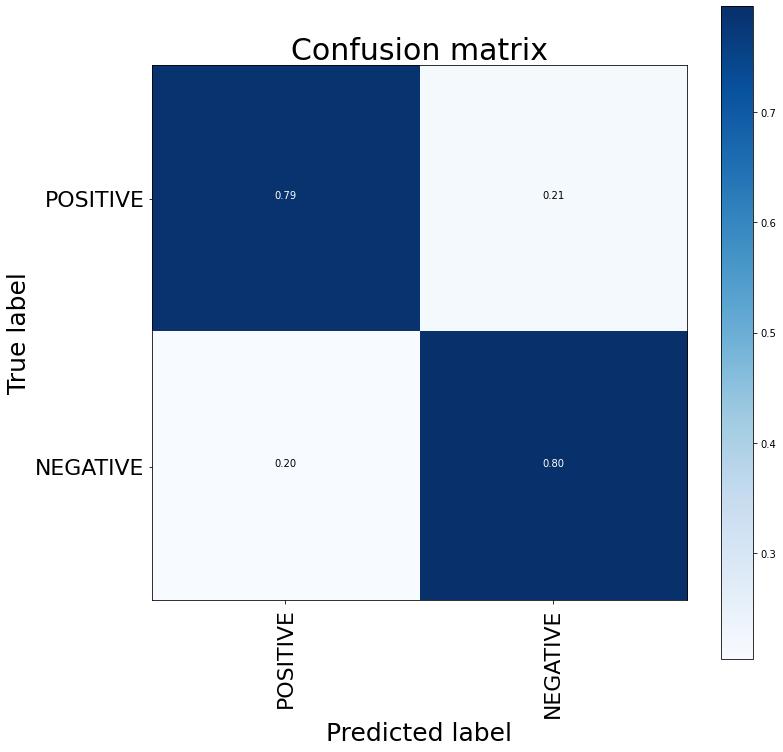

CPU times: user 1.27 s, sys: 22 ms, total: 1.29 s
Wall time: 1.38 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.791134375

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-09-22 16:44:24,490 : INFO : saving Word2Vec object under model.w2v, separately None
2020-09-22 16:44:24,492 : INFO : not storing attribute vectors_norm
2020-09-22 16:44:24,494 : INFO : not storing attribute cum_table
2020-09-22 16:44:25,679 : INFO : saved model.w2v
